## **Playing Atari games using DQN**

In this notebook, **we'll train a Deep Q-Learning agent** playing Space Invaders using [RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo), a training framework based on [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/) that provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.

We're using the [RL-Baselines-3 Zoo integration, a vanilla version of Deep Q-Learning](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html) with no extensions such as Double-DQN, Dueling-DQN, and Prioritized Experience Replay.

⬇️ Here is an example of what **you will achieve** ⬇️


In [ ]:
%%html
<video controls autoplay><source src="https://huggingface.co/ThomasSimonini/ppo-SpaceInvadersNoFrameskip-v4/resolve/main/replay.mp4" type="video/mp4"></video>

### Install RL-Baselines3 Zoo and its dependencies 📚



In [ ]:
# For now we install this update of RL-Baselines3 Zoo
!pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf

In [ ]:
!apt-get install swig cmake ffmpeg

To be able to use Atari games in Gymnasium we need to install atari package. And accept-rom-license to download the rom files (games files).

In [ ]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

### Create a virtual display

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames).

Hence the following cell will install the librairies and create and run a virtual screen 🖥

In [ ]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

### **Build the DQN**

in this step we must:
* defining a class for DQN
* Building the architecture of NN of DQN
* Building the Replay Buffer and Storing the transition
* Defining the epsilon-greedy policy
* Define the Training phase
* Updating the Target network
* Training the DQN

and that's it 😀

>**This is a sample code of implementation of DQN for Atari game from scratch [if you need for more detail]. But in the next section we train a DQN using [RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo), a training framework based on [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/) that provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.**
>
>**We're using the [RL-Baselines-3 Zoo integration, a vanilla version of Deep Q-Learning](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html) with no extensions such as Double-DQN, Dueling-DQN, and Prioritized Experience Replay.**

#### From Scratch

In [ ]:
# ======================================================================
# import the necessary libraries:
import random
import gymnasium
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
# ======================================================================

# ======================================================================
# create the Ms Pacman game environment using Gym:
env = gymnasium.make("ALE/MsPacman-v5")

# Set the state size:
state_size = (88, 80, 1)

# Get the number of actions:
action_size = env.action_space.n
# ======================================================================

In [ ]:
# ======================================================================
# Preprocess the game screen
# let's define a function called preprocess_state, which takes the game state
# (image of the game screen) as an input and returns the preprocessed game state:
color = np.array([210, 164, 74]).mean()
def preprocess_state(state):
  print(list(state))
  state = list(state)
  #Crop and resize the image:
  image = state[1:176:2, ::2]
  #Convert the image to grayscale:
  image = image.mean(axis=2)
  #Improve the image contrast:
  image[image==color] = 0
  #Normalize the image:
  image = (image - 128) / 128 - 1
  #Reshape and return the image:
  image = np.expand_dims(image.reshape(88, 80, 1), axis=0)
  return image
# ======================================================================

In [ ]:
# ======================================================================
# Defining the DQN class
class DQN:
  # First, let's define the init method
  def __init__(self, state_size, action_size):
  # Define the state size:
    self.state_size = state_size
    # Define the action size:
    self.action_size = action_size
    # Define the replay buffer:
    self.replay_buffer = deque(maxlen=5000)
    # Define the discount factor:
    self.gamma = 0.9
    # Define the epsilon value:
    self.epsilon = 0.8
    # Define the update rate at which we want to update the target network:
    self.update_rate = 1000
    # Define the main network:
    self.main_network = self.build_network()
    # Define the target network:
    self.target_network = self.build_network()
    # Copy the weights of the main network to the target network:
    self.target_network.set_weights(self.main_network.get_weights())
  # ======================================================================
  # Building the DQN (CNN Network)
  def build_network(self):
    # Define the first convolutional layer:
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=4, padding='same', input_shape=self.state_size))
    model.add(Activation('relu'))
    # Define the second convolutional layer:
    model.add(Conv2D(64, (4, 4), strides=2, padding='same'))
    model.add(Activation('relu'))
    # Define the third convolutional layer:
    model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
    model.add(Activation('relu'))
    # Flatten the feature maps obtained as a result of the third convolutional layer:
    model.add(Flatten())
    # Feed the flattened maps to the fully connected layer:
    model.add(Dense(512, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    # Compile the model with loss as MSE:
    model.compile(loss='mse', optimizer=Adam())
    # Return the model:
    return model
  # ======================================================================
  # ======================================================================
  # Storing the transition
  # we train the DQN by randomly sampling a minibatch of
  # transitions from the replay buffer. So, we define a function called store_transition,
  # which stores the transition information in the replay buffer:
  def store_transistion(self, state, action,reward, next_state, done):
    self.replay_buffer.append((state, action,reward, next_state, done))
  # ======================================================================
  # ======================================================================
  # Defining the epsilon-greedy policy
  def epsilon_greedy(self, state):
    if random.uniform(0,1) < self.epsilon:
      return np.random.randint(self.action_size)
    Q_values = self.main_network.predict(state)
    return np.argmax(Q_values[0])
  # ======================================================================
  # ======================================================================
  # Define the training phase
  # Now let's define a function called train for the training network:
  def train(self, batch_size):
    # Sample a minibatch of transitions from the replay buffer:
    minibatch = random.sample(self.replay_buffer, batch_size)
    # Compute the target value using the target network:
    for state, action, reward, next_state, done in minibatch:
      if not done:
        target_Q = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))
      else:
        target_Q = reward
        # Compute the predicted value using the main network and store the predicted value in the Q_values:
        Q_values = self.main_network.predict(state)
        # Update the target value:
        Q_values[0][action] = target_Q
        # Train the main network:
        self.main_network.fit(state, Q_values, epochs=1,verbose=0)
  # ======================================================================
  # Updating the target network
  def update_target_network(self):
    self.target_network.set_weights(self.main_network.get_weights())
  # ======================================================================
# ======================================================================

In [ ]:
# ======================================================================
# Training the DQN
# First, let's set the number of episodes we want to train the network for:
num_episodes = 500
# Define the number of time steps:
num_timesteps = 20000
# Define the batch size:
batch_size = 8
# Set the number of past game screens we want to consider:
num_screens = 4

# Instantiate the DQN class:
dqn = DQN(state_size, action_size)
# Set done to False:
done = False
# Initialize the time_step:
time_step = 0

# For each episode:
for i in range(num_episodes):
  # Set Return to 0:
  Return = 0
  # Preprocess the game screen:
  state = preprocess_state(env.reset())
  # For each step in the episode:
  for t in range(num_timesteps):
    # Render the environment:
    env.render()
    # Update the time step:
    time_step += 1
    # Update the target network:
    if time_step % dqn.update_rate == 0:
      dqn.update_target_network()
    # Select the action:
    action = dqn.epsilon_greedy(state)
    # Perform the selected action:
    next_state, reward, done, _ = env.step(action)
    # Preprocess the next state:
    next_state = preprocess_state(next_state)
    # Store the transition information:
    dqn.store_transistion(state, action, reward, next_state, done)
    # Update the current state to the next state:
    state = next_state
    # Update the return value:
    Return += reward
    # If the episode is done, then print the return:
    if done:
      print('Episode: ',i, ',' 'Return', Return)
      break
    # If the number of transitions in the replay buffer is greater than the batch size, then train the network:
    if len(dqn.replay_buffer) > batch_size:
      dqn.train(batch_size)
# ======================================================================




---



#### Using [RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo)

([Read This](https://rl-baselines3-zoo.readthedocs.io/en/master/index.html))

**Train our Deep Q-Learning Agent to Play Space Invaders 👾**

To train an agent with RL-Baselines3-Zoo, we just need to do two things:

1. Create a hyperparameter config file that will contain our training hyperparameters called `dqn.yml`.

This is a template example:

```
SpaceInvadersNoFrameskip-v4:
  env_wrapper:
    - stable_baselines3.common.atari_wrappers.AtariWrapper
  frame_stack: 4
  policy: 'CnnPolicy'
  n_timesteps: !!float 1e7
  buffer_size: 100000
  learning_rate: !!float 1e-4
  batch_size: 32
  learning_starts: 100000
  target_update_interval: 1000
  train_freq: 4
  gradient_steps: 1
  exploration_fraction: 0.1
  exploration_final_eps: 0.01
  # If True, you need to deactivate handle_timeout_termination
  # in the replay_buffer_kwargs
  optimize_memory_usage: False
```

For DQN another Hyperparameter you can check [this](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml)

and check the Unit_3-5 [DRL_HuggingFace] RL_Baseline_Zoo3 section 1-5

Here we see that:
- We use the `Atari Wrapper` that preprocess the input (Frame reduction ,grayscale, stack 4 frames)
- We use `CnnPolicy`, since we use Convolutional layers to process the frames
- We train it for 10 million `n_timesteps`
- Memory (Experience Replay) size is 100000, aka the amount of experience steps you saved to train again your agent with.

💡 My advice is to **reduce the training timesteps to 1M,** which will take about 90 minutes on a P100. `!nvidia-smi` will tell you what GPU you're using. At 10 million steps, this will take about 9 hours, which could likely result in Colab timing out. I recommend running this on your local computer (or somewhere else). Just click on: `File>Download`.

In terms of hyperparameters optimization, my advice is to focus on these 3 hyperparameters:
- `learning_rate`
- `buffer_size (Experience Memory size)`
- `batch_size`

As a good practice, you need to **check the documentation to understand what each hyperparameters does**: https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#parameters



**For config the `dqn.yml` file we need to Hyperparameter Tuning by Optuna:**

**Tune Hyperparameters automatically with zoo3 and optuna**

We use [Optuna](https://optuna.org/) for optimizing the hyperparameters.

Tune the hyperparameters for DQN, using a tpe sampler and median pruner, 2 parallels jobs,
with a budget of 100 trials and a maximum of 5000 steps:

This can help you: 🌝

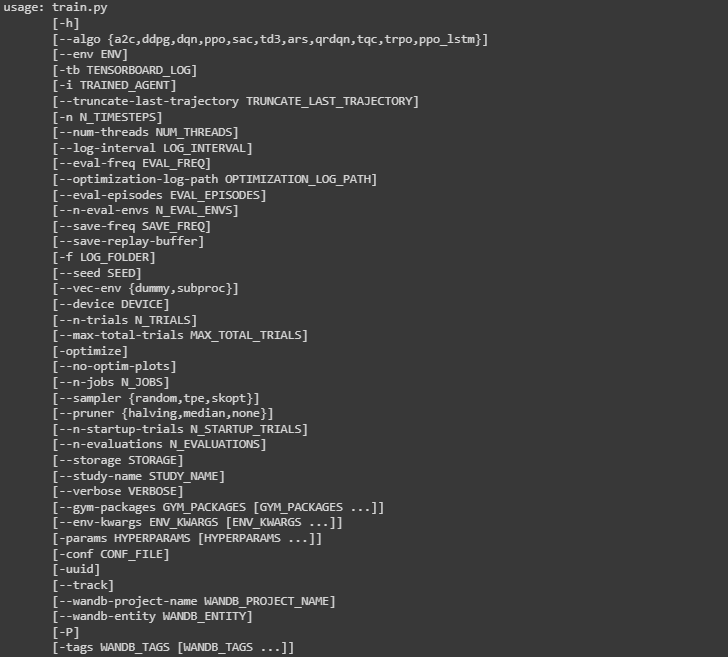

In [ ]:
!python -m rl_zoo3.train --algo dqn --env SpaceInvadersNoFrameskip-v4 -n 5000 -optimize --n-trials 100 --n-jobs 2 --sampler tpe --pruner median

2023-06-12 08:43:58.828302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 08:43:59.732723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
========== SpaceInvadersNoFrameskip-v4 ==========
Seed: 3570770334
Loading hyperparameters from: /usr/local/lib/python3.10/dist-packages/rl_zoo3/hyperparams/dqn.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 32),
             ('buffer_size', 100000),
             ('env_wrapper',
              ['stable_baselines3.common.atari_wrappers.AtariWrapper']),
             ('exploration_final_eps', 0.01),
             ('exploration_fraction', 0.1),
             ('frame_stack', 4),
             ('gradient_



---




2. We start the training and save the models on `logs` folder 📁

- Define the algorithm after `--algo`, where we save the model after `-f` and where the hyperparameter config is after `-c`.

In [ ]:
!python -m rl_zoo3.train --algo dqn  --env SpaceInvadersNoFrameskip-v4 -f logs/ -c dqn.yml

2023-06-12 10:36:57.079046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 10:36:58.063524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
========== SpaceInvadersNoFrameskip-v4 ==========
Seed: 722079798
Loading hyperparameters from: dqn.yml
Default hyperparameters for environment (ones being tuned will be overridden):
OrderedDict([('batch_size', 256),
             ('buffer_size', 100000),
             ('env_wrapper',
              ['stable_baselines3.common.atari_wrappers.AtariWrapper']),
             ('exploration_final_eps', 0.01),
             ('exploration_fraction', 0.1),
             ('frame_stack', 4),
             ('gradient_steps', 1),
             ('learning_rate', 0.034554640717951

##### Let's evaluate our agent

- RL-Baselines3-Zoo provides `enjoy.py`, a python script to evaluate our agent. In most RL libraries, we call the evaluation script `enjoy.py`.
- Let's evaluate it for 5000 timesteps 🔥

In [ ]:
!python -m rl_zoo3.enjoy  --algo dqn  --env SpaceInvadersNoFrameskip-v4  --no-render  --n-timesteps 5000  --folder logs/

2023-06-12 11:48:26.130721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 11:48:27.071368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest experiment, id=5
Loading logs/dqn/SpaceInvadersNoFrameskip-v4_5/SpaceInvadersNoFrameskip-v4.zip
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
Stacking 4 frames
Atari Episode Score: 65.00
Atari Episode Length 2769
Atari Episode Score: 90.00
Atari Episode Length 1927
Atari Episode Score: 70.00
Atari Episode Length 2749
Atari Episode Score: 140.00
Atari Episode Length 3813
Atari Episode Score: 100.00
Atari Episode Length 2977
Atari Episode Score: 65.00
Atari Episode Length 2737
Atari Episode Score: 115.00
Atari Ep

##### Record  a Video

In [ ]:
# Set up display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
!python -m rl_zoo3.record_video --algo dqn --env SpaceInvadersNoFrameskip-v4 --exp-id 0 -f logs/ -n 10000

2023-06-12 11:50:23.026603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 11:50:24.000578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest experiment, id=5
Loading logs/dqn/SpaceInvadersNoFrameskip-v4_5/SpaceInvadersNoFrameskip-v4.zip
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
Stacking 4 frames
Loading logs/dqn/SpaceInvadersNoFrameskip-v4_5/SpaceInvadersNoFrameskip-v4.zip
Wrapping the env in a VecTransposeImage.
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsisten

##### Display the video

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
show_videos(video_path='logs/dqg/SpaceInvadersNoFrameskip-v4/videos/', prefix='')



---



## **DQN in PyTorch**

In this section, **we'll train a Deep Q-Learning agent** in Gym environment using PyTorch.


* defining a class for DQN
* Building the architecture of NN of DQN
* Building the Replay Buffer and Storing the transition
* Defining the epsilon-greedy policy
* Define the Training phase
* Updating the Target network
* Training the DQN

and that's it 😀

**For Step-by-Step guide notebook for DQN check this [link](https://github.com/Curt-Park/rainbow-is-all-you-need).**

In [ ]:
# Configurations for Colab
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium
    !pip install stable-baselines3[extra]
    !pip install wandb
    !pip install gymnasium[atari,accept-rom-license]
    import ale_py
    # if using gymnasium
    import shimmy
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

import argparse
import random
import time
from distutils.util import strtobool

from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter

import stable_baselines3
from typing import Callable


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 15 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
# From StableBaseline3
class ReplayBuffer(BaseBuffer):
    """
    Replay buffer used in off-policy algorithms like SAC/TD3.

    :param buffer_size: Max number of element in the buffer
    :param observation_space: Observation space
    :param action_space: Action space
    :param device: PyTorch device
    :param n_envs: Number of parallel environments
    :param optimize_memory_usage: Enable a memory efficient variant
        of the replay buffer which reduces by almost a factor two the memory used,
        at a cost of more complexity.
        See https://github.com/DLR-RM/stable-baselines3/issues/37#issuecomment-637501195
        and https://github.com/DLR-RM/stable-baselines3/pull/28#issuecomment-637559274
        Cannot be used in combination with handle_timeout_termination.
    :param handle_timeout_termination: Handle timeout termination (due to timelimit)
        separately and treat the task as infinite horizon task.
        https://github.com/DLR-RM/stable-baselines3/issues/284
    """

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        device: Union[th.device, str] = "auto",
        n_envs: int = 1,
        optimize_memory_usage: bool = False,
        handle_timeout_termination: bool = True,
    ):
        super().__init__(buffer_size, observation_space, action_space, device, n_envs=n_envs)

        # Adjust buffer size
        self.buffer_size = max(buffer_size // n_envs, 1)

        # Check that the replay buffer can fit into the memory
        if psutil is not None:
            mem_available = psutil.virtual_memory().available

        # there is a bug if both optimize_memory_usage and handle_timeout_termination are true
        # see https://github.com/DLR-RM/stable-baselines3/issues/934
        if optimize_memory_usage and handle_timeout_termination:
            raise ValueError(
                "ReplayBuffer does not support optimize_memory_usage = True "
                "and handle_timeout_termination = True simultaneously."
            )
        self.optimize_memory_usage = optimize_memory_usage

        self.observations = np.zeros((self.buffer_size, self.n_envs) + self.obs_shape, dtype=observation_space.dtype)

        if optimize_memory_usage:
            # `observations` contains also the next observation
            self.next_observations = None
        else:
            self.next_observations = np.zeros((self.buffer_size, self.n_envs) + self.obs_shape, dtype=observation_space.dtype)

        self.actions = np.zeros((self.buffer_size, self.n_envs, self.action_dim), dtype=action_space.dtype)

        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.dones = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        # Handle timeouts termination properly if needed
        # see https://github.com/DLR-RM/stable-baselines3/issues/284
        self.handle_timeout_termination = handle_timeout_termination
        self.timeouts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)

        if psutil is not None:
            total_memory_usage = self.observations.nbytes + self.actions.nbytes + self.rewards.nbytes + self.dones.nbytes

            if self.next_observations is not None:
                total_memory_usage += self.next_observations.nbytes

            if total_memory_usage > mem_available:
                # Convert to GB
                total_memory_usage /= 1e9
                mem_available /= 1e9
                warnings.warn(
                    "This system does not have apparently enough memory to store the complete "
                    f"replay buffer {total_memory_usage:.2f}GB > {mem_available:.2f}GB"
                )

    def add(
        self,
        obs: np.ndarray,
        next_obs: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        done: np.ndarray,
        infos: List[Dict[str, Any]],
    ) -> None:
        # Reshape needed when using multiple envs with discrete observations
        # as numpy cannot broadcast (n_discrete,) to (n_discrete, 1)
        if isinstance(self.observation_space, spaces.Discrete):
            obs = obs.reshape((self.n_envs,) + self.obs_shape)
            next_obs = next_obs.reshape((self.n_envs,) + self.obs_shape)

        # Same, for actions
        action = action.reshape((self.n_envs, self.action_dim))

        # Copy to avoid modification by reference
        self.observations[self.pos] = np.array(obs).copy()

        if self.optimize_memory_usage:
            self.observations[(self.pos + 1) % self.buffer_size] = np.array(next_obs).copy()
        else:
            self.next_observations[self.pos] = np.array(next_obs).copy()

        self.actions[self.pos] = np.array(action).copy()
        self.rewards[self.pos] = np.array(reward).copy()
        self.dones[self.pos] = np.array(done).copy()

        if self.handle_timeout_termination:
            self.timeouts[self.pos] = np.array([info.get("TimeLimit.truncated", False) for info in infos])

        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True
            self.pos = 0

    def sample(self, batch_size: int, env: Optional[VecNormalize] = None) -> ReplayBufferSamples:
        """
        Sample elements from the replay buffer.
        Custom sampling when using memory efficient variant,
        as we should not sample the element with index `self.pos`
        See https://github.com/DLR-RM/stable-baselines3/pull/28#issuecomment-637559274

        :param batch_size: Number of element to sample
        :param env: associated gym VecEnv
            to normalize the observations/rewards when sampling
        :return:
        """
        if not self.optimize_memory_usage:
            return super().sample(batch_size=batch_size, env=env)
        # Do not sample the element with index `self.pos` as the transitions is invalid
        # (we use only one array to store `obs` and `next_obs`)
        if self.full:
            batch_inds = (np.random.randint(1, self.buffer_size, size=batch_size) + self.pos) % self.buffer_size
        else:
            batch_inds = np.random.randint(0, self.pos, size=batch_size)
        return self._get_samples(batch_inds, env=env)

    def _get_samples(self, batch_inds: np.ndarray, env: Optional[VecNormalize] = None) -> ReplayBufferSamples:
        # Sample randomly the env idx
        env_indices = np.random.randint(0, high=self.n_envs, size=(len(batch_inds),))

        if self.optimize_memory_usage:
            next_obs = self._normalize_obs(self.observations[(batch_inds + 1) % self.buffer_size, env_indices, :], env)
        else:
            next_obs = self._normalize_obs(self.next_observations[batch_inds, env_indices, :], env)

        data = (
            self._normalize_obs(self.observations[batch_inds, env_indices, :], env),
            self.actions[batch_inds, env_indices, :],
            next_obs,
            # Only use dones that are not due to timeouts
            # deactivated by default (timeouts is initialized as an array of False)
            (self.dones[batch_inds, env_indices] * (1 - self.timeouts[batch_inds, env_indices])).reshape(-1, 1),
            self._normalize_reward(self.rewards[batch_inds, env_indices].reshape(-1, 1), env),
        )
        return ReplayBufferSamples(*tuple(map(self.to_torch, data)))

### **DQN Network**

I implement the Article 2015: The input to the neural network consists of an 84x84x4 image produced by the preprocessing map w. The first hidden layer convolves 32 filters of 8 x 8 with stride 4 with the input image and applies a rectifier nonlinearity. The second hidden layer convolves 64 filters of 4 x 4 with stride 2, again followed by a rectifier nonlinearity. Thisisfollowed by a third convolutional layerthat convolves 64 filters of 3 x 3 3with stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists of 512 rectifier units. The output layer is a fully-connected linear layer with a single output for each valid action. The number of valid actions varied between 4 and 18 on the games we considered. (in my carRacing = 5) We refer to convolutional networks trained with our approach as Deep Q-Networks (DQN).

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        return self.network(x / 255.0)

### **DQN Agent**





In [ ]:
exp_name = "DQN.py"
seed = 1
torch_deterministic = True
cuda = True
track = True                             # experiment will be tracked with Weights and Biases
wandb_project_name = "Sarmad-DQN-cleanRL"
wandb_entity = None
capture_video = False
save_model = True                        # whether to save model into the `runs/{run_name}` folder"
upload_model = False                     # whether to upload the saved model to huggingface
hf_entity = ""                           # the user or org name of the model repository from the Hugging Face Hub


# Algorithm specific arguments
env_id = "Enduro-v4"
total_timesteps = 200000
learning_rate = 1e-4      # the learning rate of the optimizer
num_envs = 1              # the number of parallel game environments >> if num_env = 1 then vectorized envs are not supported at the moment
buffer_size = 100000      # the replay memory buffer size
gamma = 0.99              # the discount factor gamma
tau = 1.                  # the target network update rate
target_network_frequency = 1000  # the timesteps it takes to update the target network
batch_size = 32           # the batch size of sample from the reply memory
start_e = 1               # the starting epsilon for exploration
end_e = 0.01              # the ending epsilon for exploration
exploration_fraction = 0.10  # the fraction of `total-timesteps` it takes from start-e to go end-e
learning_starts = 80000   # timestep to start learning
train_frequency = 4       # the frequency of training



def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.action_space.seed(seed)

        return env

    return thunk


# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x / 255.0)


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

def evaluate(
    model_path: str,
    make_env: Callable,
    env_id: str,
    eval_episodes: int,
    run_name: str,
    Model: torch.nn.Module,
    device: torch.device = torch.device("cpu"),
    epsilon: float = 0.05,
    capture_video: bool = True,
):
    envs = gym.vector.SyncVectorEnv([make_env(env_id, 0, 0, capture_video, run_name)])
    model = Model(envs).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    obs, _ = envs.reset()
    episodic_returns = []
    while len(episodic_returns) < eval_episodes:
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            q_values = model(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()
        next_obs, _, _, _, infos = envs.step(actions)
        if "final_info" in infos:
            for info in infos["final_info"]:
                if "episode" not in info:
                    continue
                print(f"eval_episode={len(episodic_returns)}, episodic_return={info['episode']['r']}")
                episodic_returns += [info["episode"]["r"]]
        obs = next_obs

    return episodic_returns

if __name__ == "__main__":
    import stable_baselines3 as sb3

    #args = parse_args()
    run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"
    if track:
        import wandb

        wandb.init(
            project=wandb_project_name,
            entity=wandb_entity,
            sync_tensorboard=True,
            #config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/{run_name}")
    #writer.add_text(
    #    "hyperparameters",
    #    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    #)

    # TRY NOT TO MODIFY: seeding
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and cuda else "cpu")

    # env setup
    envs = gym.vector.SyncVectorEnv(
        [make_env(env_id, seed + i, i, capture_video, run_name) for i in range(num_envs)]
    )
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

    q_network = QNetwork(envs).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
    target_network = QNetwork(envs).to(device)
    target_network.load_state_dict(q_network.state_dict())

    rb = ReplayBuffer(
        buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )
    start_time = time.time()

    # TRY NOT TO MODIFY: start the game
    obs, _ = envs.reset(seed=seed)
    for global_step in range(total_timesteps):
        # ALGO LOGIC: put action logic here
        epsilon = linear_schedule(start_e, end_e, exploration_fraction * total_timesteps, global_step)
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            q_values = q_network(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, terminated, truncated, infos = envs.step(actions)

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        if "final_info" in infos:
            for info in infos["final_info"]:
                # Skip the envs that are not done
                if "episode" not in info:
                    continue
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                writer.add_scalar("charts/epsilon", epsilon, global_step)

        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(truncated):
            if d:
                real_next_obs[idx] = infos["final_observation"][idx]
        rb.add(obs, real_next_obs, actions, rewards, terminated, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs

        # ALGO LOGIC: training.
        if global_step > learning_starts:
            if global_step % train_frequency == 0:
                data = rb.sample(batch_size)
                with torch.no_grad():
                    target_max, _ = target_network(data.next_observations).max(dim=1)
                    td_target = data.rewards.flatten() + gamma * target_max * (1 - data.dones.flatten())
                old_val = q_network(data.observations).gather(1, data.actions).squeeze()
                loss = F.mse_loss(td_target, old_val)

                if global_step % 100 == 0:
                    writer.add_scalar("losses/td_loss", loss, global_step)
                    writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                    print("SPS:", int(global_step / (time.time() - start_time)))
                    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

                # optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # update target network
            if global_step % target_network_frequency == 0:
                for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                    target_network_param.data.copy_(
                        tau * q_network_param.data + (1.0 - tau) * target_network_param.data
                    )

    if save_model:
        model_path = f"runs/{run_name}/{exp_name}.cleanrl_model"
        torch.save(q_network.state_dict(), model_path)
        print(f"model saved to {model_path}")

        episodic_returns = evaluate(
            model_path,
            make_env,
            env_id,
            eval_episodes=10,
            run_name=f"{run_name}-eval",
            Model=QNetwork,
            device=device,
            epsilon=0.05,
        )
        for idx, episodic_return in enumerate(episodic_returns):
            writer.add_scalar("eval/episodic_return", episodic_return, idx)

        if upload_model:
            from cleanrl_utils.huggingface import push_to_hub

            repo_name = f"{env_id}-{exp_name}-seed{seed}"
            repo_id = f"{hf_entity}/{repo_name}" if hf_entity else repo_name
            #push_to_hub(args, episodic_returns, repo_id, "DQN", f"runs/{run_name}", f"videos/{run_name}-eval")

    envs.close()
    writer.close()

/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


global_step=1104, episodic_return=[0.]
global_step=2212, episodic_return=[0.]
global_step=3306, episodic_return=[0.]
global_step=4408, episodic_return=[0.]
global_step=5515, episodic_return=[0.]
global_step=6613, episodic_return=[0.]
global_step=7720, episodic_return=[0.]
global_step=8826, episodic_return=[0.]
global_step=9928, episodic_return=[0.]
global_step=11026, episodic_return=[0.]
global_step=12122, episodic_return=[0.]
global_step=13231, episodic_return=[0.]
global_step=14326, episodic_return=[0.]
global_step=15435, episodic_return=[0.]
global_step=16539, episodic_return=[0.]
global_step=17646, episodic_return=[0.]
global_step=18751, episodic_return=[0.]
global_step=19854, episodic_return=[0.]
global_step=20957, episodic_return=[0.]
global_step=22054, episodic_return=[0.]
global_step=23163, episodic_return=[0.]
global_step=24263, episodic_return=[0.]
global_step=25370, episodic_return=[0.]
global_step=26475, episodic_return=[0.]
global_step=27584, episodic_return=[0.]
global_st

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-0.mp4
eval_episode=0, episodic_return=[158.]
Moviepy - Building video /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-1.mp4.
Moviepy - Writing video /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-1.mp4
eval_episode=1, episodic_return=[118.]
eval_episode=2, episodic_return=[130.]
eval_episode=3, episodic_return=[129.]
eval_episode=4, episodic_return=[143.]
eval_episode=5, episodic_return=[129.]
eval_episode=6, episodic_return=[120.]
eval_episode=7, episodic_return=[102.]
Moviepy - Building video /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-8.mp4.
Moviepy - Writing video /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/Enduro-v4__DQN.py__1__1691347987-eval/rl-video-episode-8.mp4
eval_episode=8, episodic_return=[158.]
eval_episode=9, episodic_return=[143.]
